In [15]:
# ============================================================================ #
# 0. Imports & constants                                                       #
# ============================================================================ #
import pathlib
import re
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers as L   
from keras import models
from keras.mixed_precision import set_global_policy   
set_global_policy("mixed_float16")        

DATA_ROOT  = pathlib.Path("../Datasets")   
IMG_SIZE   = (224, 224)
BATCH_SIZE = 16
EPOCHS     = 30
SEED       = 42

In [16]:
# ============================================================================ #
# 1. Build train/test file lists (idx % 5 rule)                                #
# ============================================================================ #
train_files, train_labels = [], []
test_files , test_labels  = [], []

class_names   = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
class_to_idx  = {c: i for i, c in enumerate(class_names)}
pattern       = re.compile(r"(\d+)\.(jpg|jpeg|png)$", re.IGNORECASE)

for cls in class_names:
    for fp in (DATA_ROOT / cls).iterdir():
        m = pattern.search(fp.name)
        if not m:
            continue                      # skip non-image files
        idx = int(m.group(1))
        target  = test_files  if idx % 5 == 0 else train_files
        labels  = test_labels if idx % 5 == 0 else train_labels
        target.append(str(fp))
        labels.append(class_to_idx[cls])

print(f"Train images: {len(train_files)}, Test images: {len(test_files)}")

Train images: 692, Test images: 170


In [17]:
# ============================================================================ #
# 2. tf.data pipelines                                                         #
# ============================================================================ #
def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(f, y):
        img = tf.io.read_file(f)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0         # scale to [0, 1]
        return img, tf.one_hot(y, len(class_names))

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        aug = tf.keras.Sequential([
            L.RandomFlip("horizontal"),
            L.RandomRotation(0.05),
            L.RandomZoom(0.1),
            L.RandomContrast(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1024, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_files, train_labels, training=True)
test_ds  = make_ds(test_files , test_labels , training=False)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
components_1: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
ParallelMapDatasetV2: (ParallelMapDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/

2025-06-22 09:11:23.193549: I tensorflow/core/common_runtime/placer.cc:162] components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:23.193613: I tensorflow/core/common_runtime/placer.cc:162] components_1: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:23.193632: I tensorflow/core/common_runtime/placer.cc:162] TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:23.193644: I tensorflow/core/common_runtime/placer.cc:162] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:23.216479: I tensorflow/core/common_runtime/placer.cc:162] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:23.216507: I tensorflow/core/common_runtime/placer.cc:162] num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:23.216517: I tensorflow/core/common_runtime/placer.cc:162] ParallelMapDatasetV2: (Par

In [18]:
# ============================================================================ #
# 3. Custom CNN model                                                          #
# ============================================================================ #
def build_cnn(input_shape=(224, 224, 3), n_classes=len(class_names)):
    return models.Sequential([
        # Block 1
        L.Conv2D(32, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.Conv2D(32, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(),
        L.Dropout(0.25),

        # Block 2
        L.Conv2D(64, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.Conv2D(64, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(),
        L.Dropout(0.25),

        # Block 3
        L.Conv2D(128, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.Conv2D(128, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(),
        L.Dropout(0.25),

        # Head
        L.GlobalAveragePooling2D(),
        L.Dense(256, activation="relu"),
        L.Dropout(0.5),
        L.Dense(n_classes, activation="softmax")
    ], name="RiceLeafCNN")

model = build_cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/devic

2025-06-22 09:11:23.323459: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.323471: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.327717: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.327732: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.332019: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.332030: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.334585: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Model: "RiceLeafCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ ?                      │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# ============================================================================ #
# 4. Callbacks                                                                 #
# ============================================================================ #
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=6,
        min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=6, restore_best_weights=True
    )
]

In [20]:
# ============================================================================ #
# 5. Train                                                                     #
# ============================================================================ #
hist_head = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=callbacks
)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/30
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-06-22 09:11:23.387961: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.387979: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.393473: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.393487: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0


resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandle

2025-06-22 09:11:23.399416: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.399432: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.404989: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.405007: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.410388: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.410408: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.416028: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandle

2025-06-22 09:11:23.527388: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.527409: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.536271: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.536288: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.545185: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.545213: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.553026: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2025-06-22 09:11:23.592449: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.592461: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.598343: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.598360: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0


resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandle

2025-06-22 09:11:23.604654: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.604670: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.610859: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.610876: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.620679: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.620696: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.626308: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op Var

2025-06-22 09:11:23.866610: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.866627: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.873575: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.873589: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.880464: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.880481: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:23.886254: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandle

2025-06-22 09:11:24.070346: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.070358: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.075711: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.075721: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.082181: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.082197: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.088643: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/

2025-06-22 09:11:24.626783: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.626798: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_1_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.626801: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_2_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.626803: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_3_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.626805: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_4_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.626807: I tensorflow/core/common_runtime/placer.cc:162] assignvariableop_5_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:24.626809: I tensorflow/core/common_r

iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
unknown: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_6: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_7: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_8: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_9: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_10: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_11: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_12: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_13: (_Arg): /job:localhost/repli

2025-06-22 09:11:25.227454: I tensorflow/core/common_runtime/placer.cc:162] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:25.227483: I tensorflow/core/common_runtime/placer.cc:162] unknown: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:25.227485: I tensorflow/core/common_runtime/placer.cc:162] unknown_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:25.227488: I tensorflow/core/common_runtime/placer.cc:162] unknown_1: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:25.227490: I tensorflow/core/common_runtime/placer.cc:162] unknown_2: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:25.227492: I tensorflow/core/common_runtime/placer.cc:162] unknown_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:25.227494: I tensorflow/core/common_runtime/placer.cc:162] unknown_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-06-22 09:11:25.227

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:

2025-06-22 09:11:33.147142: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:33.147158: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:33.147162: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:33.147164: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:33.147167: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:33.147169: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:33.147172: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_61598 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_

2025-06-22 09:11:34.123069: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:34.123097: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:34.123106: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:34.123113: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:34.123121: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:34.123127: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:34.123134: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 29s 693ms/step - accuracy: 0.8125 - loss: 0.6212Exe

2025-06-22 09:11:35.501922: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:35.501936: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:35.501940: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:35.501944: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:35.501947: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:35.501950: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:35.501953: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 29s 688ms/step - accuracy: 0.7500 - loss: 0.7079Exe

2025-06-22 09:11:36.958685: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:36.958701: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:36.958705: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:36.958708: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:36.958711: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:36.958713: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:36.958716: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 29s 687ms/step - accuracy: 0.8750 - loss: 0.5266Exe

2025-06-22 09:11:38.386911: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:38.386930: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:38.386934: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:38.386937: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:38.386940: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:38.386943: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:38.386946: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 699ms/step - accuracy: 0.6250 - loss: 0.9603Exe

2025-06-22 09:11:39.866290: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:39.866307: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:39.866311: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:39.866313: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:39.866318: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:39.866320: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:39.866323: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 700ms/step - accuracy: 0.7500 - loss: 0.6281Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:11:41.321752: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:41.321770: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:41.321774: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:41.321777: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:41.321780: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:41.321782: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:41.321785: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 699ms/step - accuracy: 0.8750 - loss: 0.3646Exe

2025-06-22 09:11:42.771940: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:42.771957: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:42.771961: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:42.771963: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:42.771967: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:42.771969: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:42.771972: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 29s 691ms/step - accuracy: 0.7500 - loss: 0.7013Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

2025-06-22 09:11:44.223918: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:44.223934: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:44.223937: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:44.223942: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:44.223945: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:44.223947: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:44.223950: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 700ms/step - accuracy: 0.7500 - loss: 0.5849Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on

2025-06-22 09:11:45.673731: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:45.673747: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:45.673751: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:45.673755: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:45.673758: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:45.673761: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:45.673764: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 702ms/step - accuracy: 0.8125 - loss: 0.6777Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:11:47.141568: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:47.141585: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:47.141589: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:47.141592: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:47.141612: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:47.141614: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:47.141618: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:

2025-06-22 09:11:48.591503: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:48.591520: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:48.591524: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:48.591528: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:48.591532: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:48.591534: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:48.591537: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 704ms/step - accuracy: 0.9375 - loss: 0.3331Exe

2025-06-22 09:11:50.046379: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:50.046396: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:50.046400: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:50.046404: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:50.046407: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:50.046410: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:50.046413: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 29s 694ms/step - accuracy: 0.8750 - loss: 0.4276Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:11:51.520080: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:51.520097: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:51.520101: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:51.520103: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:51.520106: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:51.520109: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:51.520112: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 29s 696ms/step - accuracy: 0.8750 - loss: 0.3514Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:11:52.989017: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:52.989040: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:52.989044: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:52.989047: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:52.989050: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:52.989052: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:52.989055: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 29s 697ms/step - accuracy: 0.8750 - loss: 0.3585Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

2025-06-22 09:11:54.453109: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:54.453126: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:54.453130: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:54.453133: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:54.453138: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:54.453142: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:54.453146: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 714ms/step - accuracy: 1.0000 - loss: 0.2672Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

2025-06-22 09:11:55.925689: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:55.925706: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:55.925711: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:55.925713: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:55.925716: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:55.925719: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:55.925722: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 718ms/step - accuracy: 0.8750 - loss: 0.3416Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:11:57.395293: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:57.395309: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:57.395313: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:57.395315: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:57.395319: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:57.395321: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:57.395324: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 698ms/step - accuracy: 0.8125 - loss: 0.3376Exe

2025-06-22 09:11:58.842123: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:58.842140: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:58.842143: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:58.842146: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:58.842150: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:58.842152: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:11:58.842155: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 31s 725ms/step - accuracy: 0.6875 - loss: 1.0519Exe

2025-06-22 09:12:00.317576: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:00.317603: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:00.317608: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:00.317610: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:00.317613: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:00.317616: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:00.317619: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 32s 754ms/step - accuracy: 0.8125 - loss: 0.4310Exe

2025-06-22 09:12:01.826408: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:01.826431: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:01.826437: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:01.826442: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:01.826448: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:01.826452: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:01.826457: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 718ms/step - accuracy: 1.0000 - loss: 0.3387Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:12:03.308370: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:03.308389: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:03.308394: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:03.308396: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:03.308400: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:03.308402: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:03.308405: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 31s 738ms/step - accuracy: 0.8750 - loss: 0.4975Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

2025-06-22 09:12:04.794721: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:04.794738: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:04.794742: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:04.794745: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:04.794748: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:04.794751: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:04.794753: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 699ms/step - accuracy: 0.8125 - loss: 0.4321Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:12:06.237197: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:06.237214: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:06.237218: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:06.237220: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:06.237224: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:06.237226: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:06.237229: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 716ms/step - accuracy: 0.9375 - loss: 0.2175Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:12:07.687680: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:07.687697: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:07.687701: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:07.687703: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:07.687707: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:07.687709: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:07.687712: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 707ms/step - accuracy: 0.9375 - loss: 0.2142Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

2025-06-22 09:12:09.135991: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:09.136009: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:09.136013: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:09.136018: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:09.136022: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:09.136025: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:09.136028: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_60784 in device /job:localhost/replica:0/task:0/device:GPU:0
 1/44 ━━━━━━━━━━━━━━━━━━━━ 30s 701ms/step - accuracy: 0.7500 - loss: 0.9471Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2025-06-22 09:12:10.582338: I tensorflow/core/common_runtime/placer.cc:162] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:10.582356: I tensorflow/core/common_runtime/placer.cc:162] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:10.582360: I tensorflow/core/common_runtime/placer.cc:162] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:10.582362: I tensorflow/core/common_runtime/placer.cc:162] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:10.582366: I tensorflow/core/common_runtime/placer.cc:162] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:10.582369: I tensorflow/core/common_runtime/placer.cc:162] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-06-22 09:12:10.582372: I tensorflow/core/common_runtime/placer.cc:162] resize/Squeeze: (Squeeze): /j

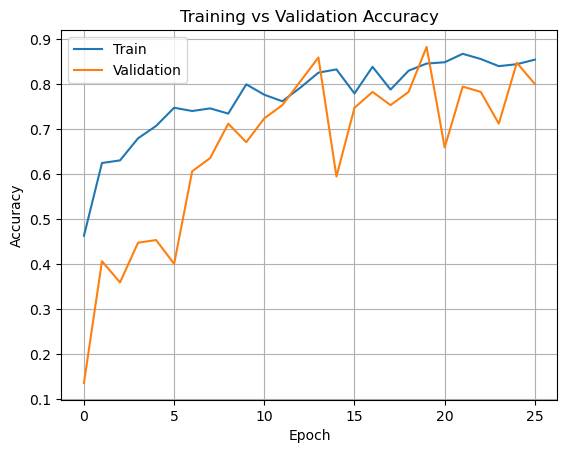

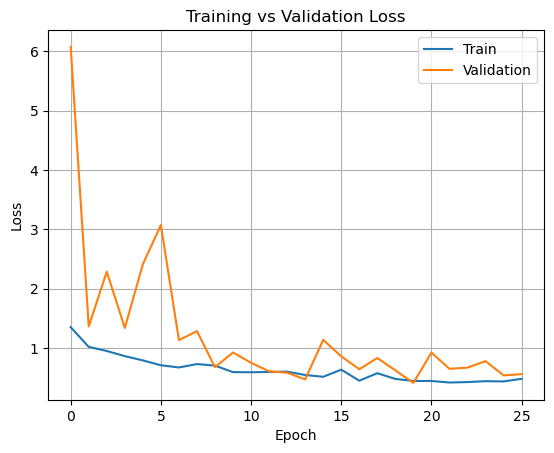

In [21]:
# ============================================================================ #
# 6. Plot accuracy & loss                                                      #
# ============================================================================ #
acc      = hist_head.history["accuracy"]
val_acc  = hist_head.history["val_accuracy"]
loss     = hist_head.history["loss"]
val_loss = hist_head.history["val_loss"]
epochs   = range(len(acc))

# Accuracy
plt.figure()
plt.plot(epochs, acc,     label="Train")
plt.plot(epochs, val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(epochs, loss,     label="Train")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [22]:
def report_best_acc(head_hist, ft_hist=None, label="Model"):
    """
    head_hist : History object returned by the head-only fit
    ft_hist   : optional History from fine-tune fit  (None → single phase)
    label     : name to print in the header
    """
    # Concatenate lists
    train_acc = head_hist.history["accuracy"] + (ft_hist.history["accuracy"]        if ft_hist else [])
    val_acc   = head_hist.history["val_accuracy"] + (ft_hist.history["val_accuracy"] if ft_hist else [])

    best_train = max(train_acc)
    best_val   = max(val_acc)

    print(f"── {label} ─────────────────────────────────────────")
    print(f"   best TRAIN accuracy : {best_train:.4f}")
    print(f"   best TEST  accuracy : {best_val  :.4f}")
    print("")

# ▸ Example for EfficientNet or ResNet (two-phase)
report_best_acc(hist_head, None, label="CNN")

── CNN ─────────────────────────────────────────
   best TRAIN accuracy : 0.8671
   best TEST  accuracy : 0.8824

